## Customer Personality Analysis with KMeans

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import sklearn
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('dataset/marketing_campaign.csv', sep = '\t')  
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


### Data Cleaning
To remove errors and modify incorrect input

In [3]:
def examine_data(data, data_name = 'data'):
    print(f"Examing '{data_name}'")
    print(f'Rows and column shape: {df.shape}\n')
    print(f'{df.info()}\n')

    # duplicate values
    duplicate = df.duplicated().sum()
    if duplicate == 0:
        print(f'Duplicate values:\n No duplicate in the {data_name}.\n')
    else:
        print(f'There are {duplicate} duplicate in the {data_name}.\n')
        
    # missing values
    print('Missing values:')
    missing = pd.DataFrame(df.isna().sum().to_frame().reset_index().\
    rename({'index': 'variables', 0: 'missing_values'}, axis = 1))
    nan_rows = missing[missing['missing_values'] > 0]
    if nan_rows['missing_values'].sum() >= 1:
            nan_rows.iplot(kind='barh', 
                         x = 'variables', 
                         colors=["blue"],
                         bargap=0.3, 
                         dimensions=(500, 250),
                         xTitle="Number of missing rows", 
                         yTitle="Missing variables", 
                         title="Missing value chart")
    else:
        print(f'There are no missing values in {data_name}.') 
    
examine_data(df, data_name = 'MARKETING DATA')

Examing 'MARKETING DATA'
Rows and column shape: (2240, 29)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 no

#### Handling missing values
The first step i took was to check the income distribution to handle the missing rows. How? or Why? when we check the distribution this helps us understand whether the column is symmetric, which makes it possible to fill with mean or median. Otherwise if it's skewed it can be dropped.

For this ananlysis, Income column is not symmetric, it is skewed, so we can not fill with mean, for the objective of the analysis, customers with missing income value ideally did not input their income or it was not stored either ways, for accuracy we will remove customers with no income value.

In [4]:
def viz_distribution(data, column, title, height=350, width= 600):
    """plot histogram.
    args:
        data(str): dataframe.
        column(str): column to plot.
        title(str): graph title.
        height(int): graph height.
        width(int): graph width.
    show:
        histogram chart
        """

    fig = px.histogram(data, column, 
                       width = width, 
                       height = height, 
                       title= title,
                       color_discrete_sequence = ['darkblue'])
    fig.show()
    
viz_distribution(df, 'Income', 'Income Distribution')

In [5]:
df.dropna(inplace = True)

#### Correlation matrix
To check relationship between variable

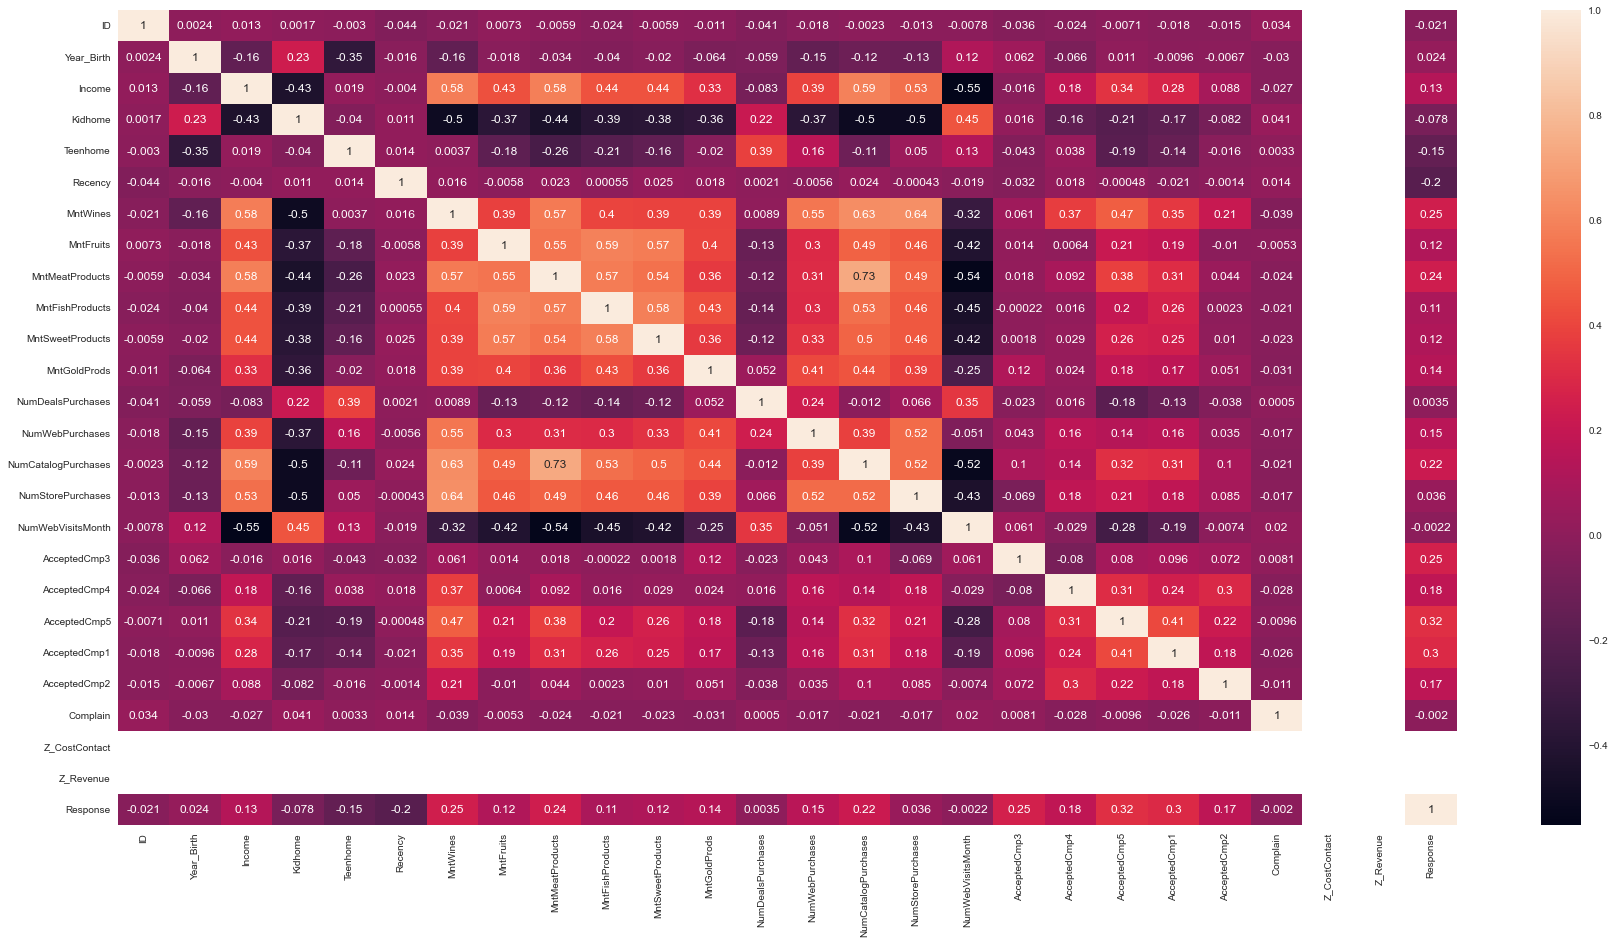

In [6]:
df.corr()
plt.figure(figsize = (30, 15))
sns.heatmap(df.corr(), annot= True);

Z_CostContact and Z_Revenue as seen in the correlation heatmap have the same values in all its column, these column will be dropped as they do not represent a statistical significant feature to the model.

In [7]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis = 1, inplace = True)

### Data wrangling
Feature Engineering: formatting the data into meaningful format for analysis.

In [8]:
# check the max year of customer erollment 
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
max(df['Dt_Customer'])

Timestamp('2014-12-06 00:00:00')

In [9]:
# create new column '2014' to get year since enrolled
df['2014'] ='2014-12-31'
df['2014'] = pd.to_datetime(df['2014'])
df['customers_engagement'] = (df['2014'].dt.year) - (df['Dt_Customer'].dt.year)  

# customers age
df['age'] = 2014 - df['Year_Birth']

# number of kids
df['kids'] = df['Kidhome'] + df['Teenhome']
     
# total amount spent
df['total_amount_spent'] = df['MntWines'] + df['MntFruits']\
    + df['MntMeatProducts'] + df['MntFishProducts']\
    + df['MntSweetProducts'] + df['MntGoldProds']

# rename product name
df = df.rename(columns ={'MntWines': 'wines', 'MntFruits':'fruits','MntMeatProducts':'meat','MntFishProducts':'fish',\
    'MntSweetProducts':'sweets','MntGoldProds':'gold'})

# delete redundant columns to reduce complexity on model
df.drop(['Year_Birth', 'Dt_Customer', 'Kidhome', 'Teenhome','AcceptedCmp3',\
         'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp4', 'AcceptedCmp5',\
         'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',\
         'NumDealsPurchases', 'NumWebVisitsMonth', '2014', 'Complain',\
         'Response'], axis = 1, inplace = True)

df.head()

,ID,Education,Marital_Status,Income,Recency,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent
0,5524,Graduation,Single,58138.0,58,635,88,546,172,88,88,2,57,0,1617
1,2174,Graduation,Single,46344.0,38,11,1,6,2,1,6,0,60,2,27
2,4141,Graduation,Together,71613.0,26,426,49,127,111,21,42,1,49,0,776
3,6182,Graduation,Together,26646.0,26,11,4,20,10,3,5,0,30,1,53
4,5324,PhD,Married,58293.0,94,173,43,118,46,27,15,0,33,1,422


In [10]:
# count of marital and education status
print(f'Categories in marital status:\n {df["Marital_Status"].value_counts()},\n')
print(f'Categories in education:\n {df["Education"].value_counts()}')

Categories in marital status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64,

Categories in education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [11]:
def replace_values(value):
    """takes a marital status value and replace to in-relationship or single.
    args: 
        value: column value.
    returns: 
        string: marital category.
    """
    
    if value == 'Married' or value == 'Together':
        return 'In relationship'
    else:
        return 'Single'
        
def apply_value(data, column):
    """create marital_status column and apply to the dataframe.
    args:
        data (str): name of dataframe.
        column (str): name of column.
    returns:
        a dataframe with the new column marital_status
        """
        
    df['marital_status'] = data[column].apply(replace_values)
    return df[:5]

apply_value(df, 'Marital_Status')

,ID,Education,Marital_Status,Income,Recency,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent,marital_status
0,5524,Graduation,Single,58138.0,58,635,88,546,172,88,88,2,57,0,1617,Single
1,2174,Graduation,Single,46344.0,38,11,1,6,2,1,6,0,60,2,27,Single
2,4141,Graduation,Together,71613.0,26,426,49,127,111,21,42,1,49,0,776,In relationship
3,6182,Graduation,Together,26646.0,26,11,4,20,10,3,5,0,30,1,53,In relationship
4,5324,PhD,Married,58293.0,94,173,43,118,46,27,15,0,33,1,422,In relationship


In [12]:
def replace_values(value):
    """takes a education value and replace to pg and ug.
    args: 
        value: column value.
    returns: 
        string: marital category.
    """
    
    if value == 'Graduation' or value == 'PhD' or value == 'Master' or value == '2n Cycle' :
        return 'PG'
    else:
        return 'UG'
        
def apply_value(data, column):
    """create education column and apply to the dataframe.
    args:
        data (str): name of dataframe.
        column (str): name of column.
    returns:
        a dataframe with the new column marital_status
        """
        
    df['education'] = data[column].apply(replace_values)
    return df[:5]

apply_value(df, 'Education')

,ID,Education,Marital_Status,Income,Recency,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent,marital_status,education
0,5524,Graduation,Single,58138.0,58,635,88,546,172,88,88,2,57,0,1617,Single,PG
1,2174,Graduation,Single,46344.0,38,11,1,6,2,1,6,0,60,2,27,Single,PG
2,4141,Graduation,Together,71613.0,26,426,49,127,111,21,42,1,49,0,776,In relationship,PG
3,6182,Graduation,Together,26646.0,26,11,4,20,10,3,5,0,30,1,53,In relationship,PG
4,5324,PhD,Married,58293.0,94,173,43,118,46,27,15,0,33,1,422,In relationship,PG


In [13]:
df = df.drop(['Education', 'Marital_Status'], axis=1) #Drop replicate column
df.columns = df.columns.str.lower() #Rename column name into appropriate format

### Handle outliers
Outlier are completely different numerical type of data from the dataset.

In [14]:
viz_distribution(df, 'age', 'Age Distribution')

Remove outliers
1. There're outliners in age and income column.
2. It is observed that majority of our customers earn between <= 90k, income above 600,000 will be removed.
3. Age greater than 100 will be remove, these customers can be treated differently, the age inputed could be a result of incorrect  entry.

In [15]:
# customer with the large income and age
df_outliers = df[(df['age']> 100) | (df['income']>600000)]
df_outliers

,id,income,recency,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent,marital_status,education
192,7829,36640.0,99,15,6,8,7,4,25,1,114,1,65,Single,PG
239,11004,60182.0,23,8,0,5,7,0,2,0,121,1,22,Single,PG
339,1150,83532.0,36,755,144,562,104,64,224,1,115,0,1853,In relationship,PG
2233,9432,666666.0,23,9,14,18,8,1,12,1,37,1,62,In relationship,PG


In [16]:
# new data after removing outliers
df = df[(df['age'] < 100) & (df['income'] < 600000)]

### Data Exploration
Visualize categorical variables using univariate and bivariate analysis.

In [18]:
def viz_group(data, row, column, color, title):
    """ plot a group bar chart.
    args:
        data (str): dataframe.
        row (list): list of x-axis.
        column (str): y-axis.
        title (str): graph name.
        height (int): graph height.
        width (int): graph width.
    show:
        grouped bar chart
    """
        
    fig = px.bar(data, row, column,
             color = color, 
             barmode = 'group',
             height = 400,
             width = 600,
             title = title,
             color_discrete_sequence = ['darkblue', 'orange'])
    fig.show()

df_marital_edu_count = df.groupby(['marital_status', 'education'])['id'].count().to_frame().reset_index()

viz_group(df_marital_edu_count, 'marital_status', 'id',  'education', 'Number of customers based on marital vs education status') 

In [19]:
df_marital_edu_value = df.groupby(['marital_status', 'education'])['total_amount_spent'].sum().to_frame().reset_index()

viz_group(df_marital_edu_value, 'marital_status', 'total_amount_spent',  'education', 'Purchases made by customers') 

In [20]:
def viz_pie(data,  values, name, color, title):
    """ plot a pie chart.
    args:
        data (str): dataframe.
        values (str): row to be counted.
        name (str): name of column.
        color (str): additional column
        title (str): graph name.
    show:
        ringed pie chart
    """

    fig = px.pie(data, 
                 values = values, 
                 names = name, 
                 title = title, 
                 hole = 0.4, 
                 width = 600,
                 color_discrete_sequence = ['darkblue', 'orange'])
    fig.update_traces(textinfo = 'percent', textfont_size = 15)
    fig.show()
    
df_marital = df.groupby('marital_status')['id'].count().to_frame().reset_index()

viz_pie(df_marital , df_marital['id'], df_marital['marital_status'], df_marital['marital_status'], 'Number of customers by marital status')

In [21]:
df_edu = df.groupby('education')['id'].sum().to_frame().reset_index()

viz_pie(df_edu , df_edu['id'], df_edu['education'], df_edu['education'], 'Number of custmers by education')

In [22]:
def viz_bar(data, row = [], column = 'column', title ='title', height=400, width=800):
    """ plot a group bar chart.
    args:
        data (str): dataframe.
        row (list): list of x-axis.
        column (str): y-axis.
        title (str): graph name.
        height (int): graph height.
        width (int): graph width.
    show:
        grouped horizontal bar chart
    """
        
    fig = px.bar(data, row, column, 
             barmode = 'group',
             height = height,
             width = width,
             title = title,
             color_discrete_sequence =  ['darkblue', 'orange', 'red', 'black', 'darkgreen', 'purple'])
    fig.show()

df_marital2 = df.groupby('marital_status')['wines', 'fruits', 'meat', 'fish',	'sweets', 'gold'].sum().reset_index()

viz_bar(df_marital2, ['wines', 'fruits', 'meat', 'fish', 'sweets', 'gold'], 'marital_status', 'Marital status by purchase of product') 

In [23]:
df_edu2 = df.groupby('education')['wines', 'fruits', 'meat', 'fish',	'sweets', 'gold'].sum().reset_index()

viz_bar(df_edu2, ['wines', 'fruits', 'meat', 'fish', 'sweets', 'gold'], 'education', 'Education by purchase of product') 

### Observation
1. Majority of our customers are post-graduate and in-relationship customers. Of our customers 65% are in a relationship and 98% are in PG school
2. PG customers purchase engrossively more compare to UG customers, out of the PG customers who purchase more, people in-relationship have purchased approximately $850 worth of product than the single people who have purchased 488 worth of product.
3. In terms of value, the major product widely purchased by PG and in-relationship customers is Wine and Meat.

In summary our best purchasing customers are customers in a relationship and PG school.

### Data Preprocessing

In [24]:
df_main = df
df = df_main.copy()

### Label encoding
Encode category column to numeric.

In [25]:
categorical_col = df.select_dtypes('object').columns

label_encoder = LabelEncoder()
for column in categorical_col:
    df[column] = df[[column]].apply(label_encoder.fit_transform)   

### Standardization
To resize the the distribution of the values, where the mean is observed to be 0 and standard deviation is 1.

In [26]:
new_df = df.copy()
new_df.drop(['id'],axis=1, inplace= True)  #drop id column

scaled_features = StandardScaler().fit_transform(new_df)
scaled_features_df = pd.DataFrame(scaled_features, columns=new_df.columns)
scaled_features_df.head()

,income,recency,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent,marital_status,education
0,0.287105,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,1.499086,1.018352,-1.264598,1.676245,1.349603,-0.158187
1,-0.260882,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-1.417341,1.274785,1.404572,-0.963297,1.349603,-0.158187
2,0.913196,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,0.040872,0.334530,-1.264598,0.280110,-0.740959,-0.158187
3,-1.176114,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-1.417341,-1.289547,0.069987,-0.920135,-0.740959,-0.158187
4,0.294307,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,-1.417341,-1.033114,0.069987,-0.307562,-0.740959,-0.158187


### Dimensionality reduction
Dimensionality reduction is introduced in this section inorder to eliminate redundant features. Removing redundant features improve the model learning speed. One of the method to remove redundant features is Principle Component Analysis(PCA) it is an unsupervised techniques that is used to reduce dimensionality in the dataset so as to increase interpretability and also minimise information loss.

Dimensionality reduction with PCA

For this analysis, i will reduce the dimensionality to 4

In [27]:
pca = PCA(n_components=4)
pca.fit(scaled_features_df)
pca_df = pd.DataFrame(pca.transform(scaled_features_df), columns=(["column1", "column2", "column3", "column4"]))

### Clustering and Elbow method
For clustering, I used the Agglomerative hierarchical clustering, an unsupervised learning model use to group objects in clusters based on their similarities and merge them together. Used the elbow method to determine the number of clusters

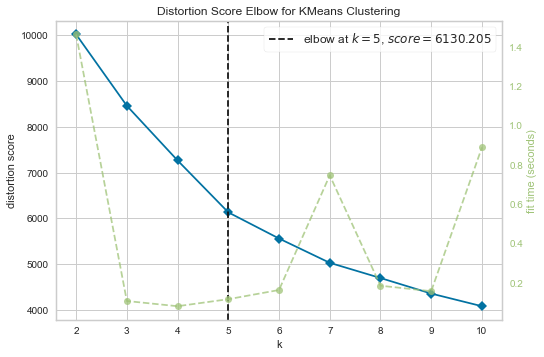

In [28]:
# elbow method to find numbers of clusters to make.
kmeans = KMeans()
elbow_method = KElbowVisualizer((kmeans), k=10)
elbow_method.fit(pca_df)
elbow_method.show();

The above graph visualize the optimal number of segment in the dataset.

### Agglomerative method 

In [29]:
ac = AgglomerativeClustering(n_clusters=5)

ac_clstering = ac.fit_predict(pca_df)
pca_df["cluster"] = ac_clstering

df_main["cluster"]= ac_clstering # adding cluster feature to the orignal dataframe.
df_main['cluster'] = 'cluster'+ ' ' + df_main['cluster'].astype('str')
df_main.head()

,id,income,recency,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent,marital_status,education,cluster
0,5524,58138.0,58,635,88,546,172,88,88,2,57,0,1617,Single,PG,cluster 0
1,2174,46344.0,38,11,1,6,2,1,6,0,60,2,27,Single,PG,cluster 3
2,4141,71613.0,26,426,49,127,111,21,42,1,49,0,776,In relationship,PG,cluster 0
3,6182,26646.0,26,11,4,20,10,3,5,0,30,1,53,In relationship,PG,cluster 1
4,5324,58293.0,94,173,43,118,46,27,15,0,33,1,422,In relationship,PG,cluster 2


In [30]:
# plotting the 3d clusters
plot_fig = go.Figure()
for column in list(df_main.cluster.unique()):
    plot_fig.add_trace(go.Scatter3d(
     x = df_main[df_main.cluster == column]['income'],
     y = df_main[df_main.cluster == column]['age'],
     z = df_main[df_main.cluster == column]['total_amount_spent'],                        
     mode = 'markers', marker_size = 6, marker_line_width = 1,
     name = str(column)
                                ))
    
plot_fig.update_traces(hovertemplate='Income: %{x} <br>Age: %{y} <br>total_amount_spent: %{z}')

    
plot_fig.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Income', titlefont_color = 'black'),
                                yaxis=dict(title = 'Age', titlefont_color = 'black'),
                                zaxis=dict(title = 'Expense', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

In [31]:
viz_distribution(df_main, 'cluster', 'Distribution of Clusters', 500, 600)

from the above chart , cluster 3 have the lowest number in the category, we can check in the original data to see their performance.

In [32]:
df_main[df_main['cluster']=='cluster 3'][:10]

,id,income,recency,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent,marital_status,education,cluster
1,2174,46344.0,38,11,1,6,2,1,6,0,60,2,27,Single,PG,cluster 3
13,8180,59354.0,53,233,2,53,3,5,14,1,62,2,310,Single,PG,cluster 3
19,2278,33812.0,86,4,17,19,30,24,39,2,29,1,133,Single,PG,cluster 3
25,7892,18589.0,89,6,4,25,15,12,13,1,45,0,75,Single,PG,cluster 3
30,6864,10979.0,34,8,4,10,2,2,4,0,25,0,30,Single,PG,cluster 3
33,7373,46610.0,8,96,12,96,33,22,43,2,62,2,302,Single,PG,cluster 3
35,10738,49389.0,55,40,0,19,2,1,3,1,63,2,65,Single,PG,cluster 3
38,8595,42429.0,99,55,0,6,2,0,4,0,41,1,67,Single,PG,cluster 3
50,8614,65486.0,29,245,19,125,37,67,14,0,57,1,507,Single,PG,cluster 3
52,1331,35790.0,54,12,6,20,30,1,3,1,37,1,72,Single,PG,cluster 3


#### Product Purchased per Clusters

In [33]:
product = df_main.groupby('cluster')['wines', 'fruits', 'meat', 'fish',	'sweets', 'gold'].sum().reset_index()

viz_bar(product, ['wines', 'fruits', 'meat', 'fish', 'sweets', 'gold'], 'cluster', 'Product Purchased per Clusters', 600, 1000) 

#### Cluster's Profile Based On Income And Spending

In [34]:
fig = px.scatter(df_main, 
                 x=df_main["total_amount_spent"], 
                 y=df_main["income"],      
                 color= df_main["cluster"], 
                 hover_data=['id'],
                 title ="Cluster's Profile Based On Income And Spending")

fig.show()

#### Which of the clusters spend more compared to their income?

In [35]:
income_spent = df_main.groupby('cluster')['total_amount_spent', 'income'].sum().reset_index()

viz_bar(income_spent, ['total_amount_spent', 'income'], 'cluster', 'Clusters Aggregate Income vs Spending', 500, 900) 

#### Which among the clusters engage with our product more?

In [36]:
cust_engagement = df_main.groupby('cluster')['customers_engagement'].sum().reset_index()

viz_bar(cust_engagement, ['customers_engagement'], 'cluster', 'Clusters Aggregate Income vs Spending') 

### Insight 
1. All the customer in each clusters purchase more of meat and wines compared to other product. With wine having more purchase than meat.

2. Meat and Wine is mostly consumed by cluster 2 and 0.

3. The income effect of spending habit in each clusters:

* cluster 1: high income and high purchase

* cluster 2:high income and high purchase

* cluster 3:less income and low purchase

* cluster 4: average income and average purchse

* cluster 0:average income and high purchase

4. Customers don't spend much compared to what they earn as income.

5. In terms of customers engagement cluster 0,1 and 2 are responsive compared to cluster 3 and 4